In [1]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd

In [1]:
import pickle

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [7]:
import mlflow


mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment3")

2023/05/18 21:54:07 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment3' does not exist. Creating a new experiment.


<Experiment: artifact_location='./mlruns/3', creation_time=1684427047615, experiment_id='3', last_update_time=1684427047615, lifecycle_stage='active', name='nyc-taxi-experiment3', tags={}>

In [15]:
df = pd.read_parquet('./green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [16]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.838799799886667

C:\Users\sairam\AppData\Local\Temp\ipykernel_10692\1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\sairam\AppData\Local\Temp\ipykernel_10692\1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


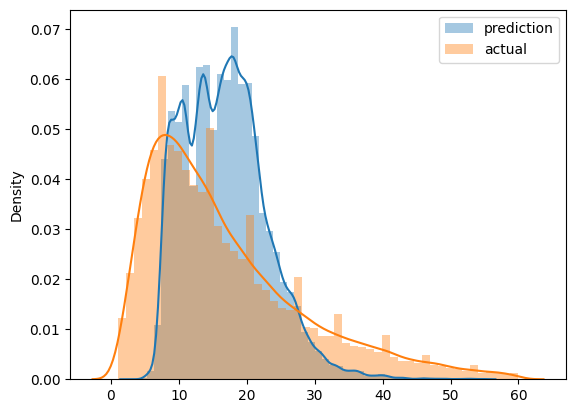

In [17]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [18]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [19]:
df_train = read_dataframe('./green_tripdata_2021-01.parquet')
df_val = read_dataframe('./green_tripdata_2021-02.parquet')

In [20]:
len(df_train), len(df_val)

(73908, 61921)

In [21]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [22]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [23]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [24]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715199477344

In [25]:
with open('models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv,lr),f_out)

In [28]:
with mlflow.start_run():
    mlflow.set_tag("developer","siddharth")
    mlflow.log_param("train-data-path", "./green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./green_tripdata_2021-02.parquet")
    alpha=0.02

    mlflow.log_param("alpha",alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)

    # get RMSE and record on mlflow
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print("RMSE for training data:", rmse)
    mlflow.log_metric("rmse", rmse)


RMSE for training data: 11.519418692961423


In [51]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [52]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}


In [53]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

In [34]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()
)

[00:01:14] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:20.07900                          
[1]	validation-rmse:19.04182                          
[2]	validation-rmse:18.07563                          
[3]	validation-rmse:17.17701                          
[4]	validation-rmse:16.34136                          
[5]	validation-rmse:15.56546                          
[6]	validation-rmse:14.84517                          
[7]	validation-rmse:14.17695                          
[8]	validation-rmse:13.55842                          
[9]	validation-rmse:12.98568                          
[10]	validation-rmse:12.45685                         
[11]	validation-rmse:11.96848                         
[12]	validation-rmse:11.51742                         
[13]	validation-rmse:11.10296                         

In [54]:
#building another model
# Hyperparameter for run 09923bbad64045ca837a1656254ce756 that gave best result with best params

search_space = {
    'max_depth': 4,
    'learning_rate': 0.14493221791716185,
    'reg_alpha': 0.012153110171030913,
    'reg_lambda': 0.017881159785939696,
    'min_child_weight': 0.674864917045824,
    'objective': 'reg:linear',
    'seed': 42
}

In [56]:
mlflow.xgboost.autolog()

booster = xgb.train(
            params=search_space,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

2023/05/19 00:43:08 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/05/19 00:43:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dda06059a16842028d68056528b02a8d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[00:43:08] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.63868
[1]	validation-rmse:16.49396
[2]	validation-rmse:14.70094
[3]	validation-rmse:13.20790
[4]	validation-rmse:11.97595
[5]	validation-rmse:10.96357
[6]	validation-rmse:10.13931
[7]	validation-rmse:9.46924
[8]	validation-rmse:8.92971
[9]	validation-rmse:8.49708
[10]	validation-rmse:8.15176
[11]	validation-rmse:7.87715
[12]	validation-rmse:7.65788
[13]	validation-rmse:7.48524
[14]	validation-rmse:7.34648
[15]	validation-rmse:7.23560
[16]	validation-rmse:7.14582
[17]	validation-rmse:7.07300
[18]	validation-rmse:7.01511
[19]	validation-rmse:6.96813
[20]	validation-rmse:6.93084
[21]	validation-rmse:6.89955
[22]	validation-rmse:6.87597
[23]	validation-rmse:6.85481
[24]	validation-rmse:6.83645
[25]	validation-rmse:6.82180
[26]	validation-rm

In [ ]:
#########   model management

'''
####   saving the model as an artifact
#1st way
with mlflow.start_run():
    mlflow.set_tag("developer","siddharth")
    mlflow.log_param("train-data-path", "./green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./green_tripdata_2021-02.parquet")
    alpha=0.02

    mlflow.log_param("alpha",alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)

    # get RMSE and record on mlflow
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print("RMSE for training data:", rmse)
    mlflow.log_metric("rmse", rmse)
    
    mlflow.log_artifact(local_path="models/lin_reg.bin",artifact_path="models_pickle/")

'''

In [68]:
    # Adapting from our previous XGBoost model, we will save the artifact into MLflow and log the parameters manually
    # We will also log the DictVectorizer preprocessor as an artifact
    #1st way to loag the model 
    # Turn off autolog
    #2nd way
    mlflow.xgboost.autolog(disable=True)


    with mlflow.start_run():
        # Hyperparameter for run 09923bbad64045ca837a1656254ce756
        params = {
            'max_depth': 4,
            'learning_rate': 0.14493221791716185,
            'reg_alpha': 0.012153110171030913,
            'reg_lambda': 0.017881159785939696,
            'min_child_weight': 0.674864917045824,
            'objective': 'reg:linear',
            'seed': 42
        }

        mlflow.log_params(params)
        

        booster = xgb.train(
                    params=params,
                    dtrain=train,
                    num_boost_round=1000,
                    evals=[(valid, 'validation')],
                    early_stopping_rounds=50
                )

        # get the y_pred from X_train
        y_pred = booster.predict(valid)

        # get RMSE and record on mlflow
        rmse = round(mean_squared_error(y_val, y_pred, squared=False),2)
        print("RMSE for training data:", rmse)
        mlflow.log_metric("rmse", rmse)

        # log xgboost model to mlflow
        mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

        # log the preprocessor DictVectorizer
        with open("models/preprocessor.bin", "wb") as f_out:
            pickle.dump(dv, f_out)

        mlflow.log_artifact("models/preprocessor.bin", artifact_path="preprocessor")


[01:46:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.63868
[1]	validation-rmse:16.49396
[2]	validation-rmse:14.70094
[3]	validation-rmse:13.20790
[4]	validation-rmse:11.97595
[5]	validation-rmse:10.96357
[6]	validation-rmse:10.13931
[7]	validation-rmse:9.46924
[8]	validation-rmse:8.92971
[9]	validation-rmse:8.49708
[10]	validation-rmse:8.15176
[11]	validation-rmse:7.87715
[12]	validation-rmse:7.65788
[13]	validation-rmse:7.48524
[14]	validation-rmse:7.34648
[15]	validation-rmse:7.23560
[16]	validation-rmse:7.14582
[17]	validation-rmse:7.07300
[18]	validation-rmse:7.01511
[19]	validation-rmse:6.96813
[20]	validation-rmse:6.93084
[21]	validation-rmse:6.89955
[22]	validation-rmse:6.87597
[23]	validation-rmse:6.85481
[24]	validation-rmse:6.83645
[25]	validation-rmse:6.82180
[26]	validation-rm

In [74]:
import mlflow
logged_model = 'runs:/94bb1baff345425f9d710fee2a40111e/models_mlflow'
loaded_model=mlflow.pyfunc.load_model(logged_model)


[01:55:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [75]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 94bb1baff345425f9d710fee2a40111e

In [77]:
xgboost_model= mlflow.xgboost.load_model(logged_model)

[01:57:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [78]:
xgboost_model

In [79]:
y_pred=xgboost_model.predict(valid)


In [80]:
y_pred[:10]

array([16.649584 ,  7.0779514, 18.543997 , 24.335464 , 10.205289 ,
       17.21065  , 13.963363 ,  9.741635 ,  8.693414 , 17.675266 ],
      dtype=float32)

In [ ]:
##model registry
#use inbuilt fn to register the model and to stage the model

In [82]:
#using mlflow client
from mlflow import tracking

from mlflow.tracking import MlflowClient
# instantiate the client
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [83]:
# we can create experiments
#With the Client, we can create experiments
client.create_experiment(name="test")

'4'

In [ ]:
'''
#list experiments and list the runs of a specific experiment
client.list_experiments()

#### Get the runs in `nyc-taxi-experiment`


    from mlflow.entities import ViewType
    runs = client.search_runs(
        experiment_ids= "2",
        filter_string="",
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=5,
        order_by=["metrics.rmse ASC"]
    )
    # the runs have a ton of information, but we can choose to only view the run_id and rmse
        for run in runs:
            print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['rmse']}")
    '''

In [88]:
client.create_experiment(name="sample_experiment")

'5'

In [89]:
#Registering a New Model
    # import and set up mlflow
import mlflow

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [ ]:
#client.list_registered_models()
#let's ensure that the run has not been registered
#assert client.search_model_versions(f"run_id = '{RUN_ID}'") == [], "Run has been registered!"

In [ ]:
# set up variables
RUN_ID = "76033bf19b524b12849032b1675fe01c"
MODEL_URI = f"runs:/{RUN_ID}/model"
mlflow.register_model(model_uri = MODEL_URI, name="nyctaxi_tripduration_regressor")

In [91]:
import mlflow
#registring the model
RUN_ID = "5e940bb6fb974f6ebcf79d11d467b9bb"
MODEL_URI = f""

mlflow.register_model(model_uri=MODEL_URI, name="nyctaxi_tripduration_regressor")


Successfully registered model 'nyctaxi_tripduration_regressor'.
2023/05/19 03:24:17 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: nyctaxi_tripduration_regressor, version 1
Created version '1' of model 'nyctaxi_tripduration_regressor'.


<ModelVersion: creation_timestamp=1684446857374, current_stage='None', description=None, last_updated_timestamp=1684446857374, name='nyctaxi_tripduration_regressor', run_id=None, run_link=None, source='', status='READY', status_message=None, tags={}, user_id=None, version=1>

In [92]:
# get the latest versions of a model
model_name = "nyctaxi_tripduration_regressor"
latest_versions = client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"Version: {version.version}, Stage: {version.current_stage}")

Version: 1, Stage: None


In [ ]:
# to transition a specific version of  a model
stage = "Staging"
version = 5

client.transition_model_version_stage(
        name = model_name,
        version = version,
        stage = stage,
        archive_existing_versions = False
    )
